# analyze 30 s data sets

### Condensed version of things for Jullian

In [8]:
%matplotlib inline
import os
#import computeDEL
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
#import wrapFunctions #import wrap180, wrap360, wrapList
import glob
import pandas as pd
#from ggplot import *
import seaborn as sns
from scipy import stats

## Parameters

In [9]:
dataFolder = 'data30'
dataFile  = os.path.join(dataFolder,'dataFile.csv')

figFolder = 'signalPlots_Update'
maxminFolder = 'maxminPlots_Update'

lowTurb = False # Limit by TI?
tiLim = 6. # % TI to limit to 

## Load the data file

In [10]:
df = pd.read_csv(dataFile)

## Analysis

In [11]:
# Make output folder
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
if not os.path.exists(maxminFolder):
    os.makedirs(maxminFolder)

In [12]:
# Add a channel which is cut wind speed and direction
binEdge = np.arange(3.,20.)
binEdge = np.arange(3.,16.)
df['windRange'] = pd.cut(df.WS1_90m_mean,binEdge,right=True)

binEdge = np.arange(-45.,55.,5) - 2.5
binLabel = range(-45,50,5)
#df['dirBin'] = pd.cut(df.apparantVane_mean,binEdge,right=True,labels=binLabel)
df['dirBin'] = pd.cut(df.WD_Nacelle_mean - 180.,binEdge,right=True,labels=binLabel)

In [13]:
# Limit by TI if told to:
if lowTurb:
    df['TI'] = 100. * df.WS1_90m_std / df.WS1_90m_mean
    df = df[df.TI < tiLim]
    df = df.drop('TI',axis=1)

In [14]:
# Set the style
sns.set_style("ticks",{"axes;grid": True})

In [15]:
# Grab a sigList
sigList = df.columns[:-2]

## Quick plot of wind direction comparison

In [16]:
for s in sigList:
    print s

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(s)? (<ipython-input-16-6a3ecafab0c6>, line 2)

In [17]:
# Limit to regions with low nacelle error for first plot, which compares the measurement
# between turbine and met mast
dfTemp = df[ abs(df.WD_Nacelle_mean - 180.) < 5.]
dfTemp = dfTemp[ dfTemp.ApparentPower_mean > 150.] # Make sure some power being produced
dfTemp.shape

(11710, 132)

7.621391973807579


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


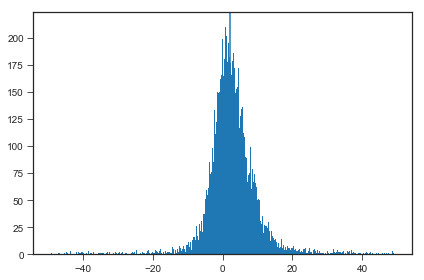

In [27]:
dfTemp['turbinePos'] = dfTemp.Yaw_Encoder_mean + (df.WD_Nacelle_mean - 180.)
fig, ax = plt.subplots()
#ax.plot(dfTemp.WD1_87m_mean,dfTemp.turbinePos,'.')
ax.hist(dfTemp.WD1_87m_mean-dfTemp.turbinePos,bins=500)
ax.set_xlim([-30,30])
ax.axvline(2)
print np.std(dfTemp.WD1_87m_mean-dfTemp.turbinePos)

In [15]:
# For second plot, just limit to where lidar is close to 0, inicating we were trying to track to 0 yaw misalignment
dfTemp = df[ df.LidarOffset_mean > -1.]
dfTemp = dfTemp[ dfTemp.ApparentPower_mean > 150.] # Make sure some power being produced
dfTemp.shape


(21457, 132)

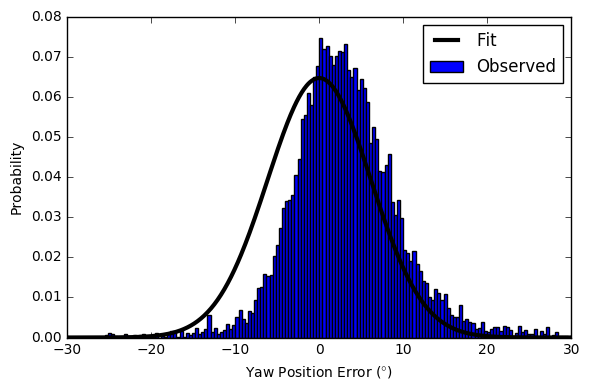

In [36]:
fig, ax = plt.subplots()
ax.hist(dfTemp.apparantVane_mean,bins=500, normed=True, label="Observed")
ax.set_xlim([-30,30])
#ax.axvline(2)
import numpy
x = np.arange(-30, 30, .1)
ax.plot(x, stats.norm.pdf(x, 0, 6.16), lw=3, c='k', label="Fit")
ax.legend()
ax.set_xlabel("Yaw Position Error" r" ($\degree$)")
ax.set_ylabel("Probability")
plt.savefig("YawObsNREL.pdf")